In [1]:
# Import statements

# Data Processing
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, RocCurveDisplay, PrecisionRecallDisplay, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline

## 3.1. Logistic Regression

- Import preprocessed features as DataFrames and target variables as Series

In [2]:
# training and test sets with original data distribution

X_train = pd.read_csv('data/X_train.csv')
y_train = pd.read_csv('data/y_train.csv', squeeze=True)

X_test = pd.read_csv('data/X_test.csv')
y_test = pd.read_csv('data/y_test.csv', squeeze=True)

In [3]:
# resampled / balanced training sets

X_train_rus = pd.read_csv('data/X_train_rus.csv')
y_train_rus = pd.read_csv('data/y_train_rus.csv', squeeze=True)

X_train_ros = pd.read_csv('data/X_train_ros.csv')
y_train_ros = pd.read_csv('data/y_train_ros.csv', squeeze=True)

X_train_smote = pd.read_csv('data/X_train_smote.csv')
y_train_smote = pd.read_csv('data/y_train_smote.csv', squeeze=True)

### 3.1.1 Initial Model Building
[Back to top](#top)

- First logistic regression model: We set the maximal number of iterations to ``max_iter=1000`` which allows the solver to converge. Apart from that we use the default hyperparameter values.

In [83]:
# Create pipeline
clf = make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=1000, random_state=42))

# Scale and fit model on training data
%time clf.fit(X_train, y_train)

Wall time: 9.8 s


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [5]:
# Predict labels
y_pred = clf.predict(X_test)

In [6]:
clf.score(X_test, y_test)

0.9118568232662192

Our first impression is a good accuracy of 91%. However, having the data imbalance in mind, we will evaluate the model in detail.

### 3.1.2. Model Evaluation 

Count of 0 in test set: 16307, (91.2025%)
Count of 1 in test set: 1573, (8.7975%)


C:\Users\fabio\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='readmitted_within_30_days', ylabel='count'>

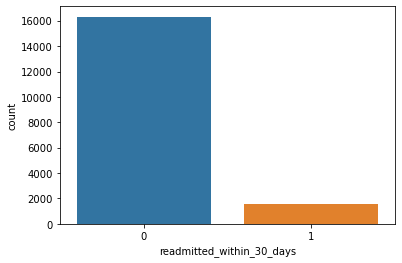

In [7]:
count_0 = (y_test == 0).sum()
count_1 = (y_test == 1).sum()

print(f'Count of 0 in test set: {count_0}, ({round(count_0 / len(y_test) * 100, 4)}%)')
print(f'Count of 1 in test set: {count_1}, ({round(count_1 / len(y_test) * 100, 4)}%)')

sns.countplot(y_test)

The '0' class has a share of 91.2% of all target values in the test data. This means a simple estimator which is always predicting 0 will have an accuracy of 91.2% while evaluated on this data set.

In [8]:
# Classifier which is always predicting the majority class label

simplest_clf = DummyClassifier()
simplest_clf.fit(X_train, y_train)
simplest_clf.score(X_test, y_test)

0.9120246085011185

Consequently, our trained logistic regression model does not have a satisfying accuracy since it is in fact less accurate than the simplest model imaginable!

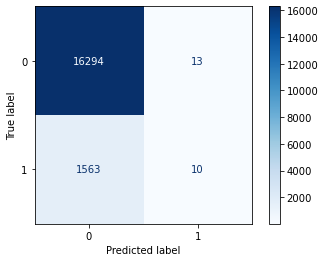

In [9]:
# scikit-learn 1.0 needed

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')

In the confusion matrix, the data imbalance becomes obvious. The majority of the instances in the test dataset is classified correctly ($\rightarrow$ therefore the 'good' accuracy), the large majority in the 'True Negative' section. Out of the 17,880 instances, the classifier predicted only 23 instances as '1', and only 10 of these predictions were correct. As we are interested in a model which identifies patients which will be readmitted to the hospital, this model is as worse as it can get. This becomes even clearer if we normalize the counts display in the confusion matrix over the true conditions:

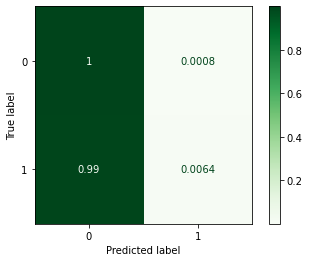

In [10]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Greens', normalize='true')

While only 0.0008% of all '0' instances are misclassified as '1', 99% of all '1' instances are misclassified as '0'!

In [11]:
# Print evaluation metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     16307
           1       0.43      0.01      0.01      1573

    accuracy                           0.91     17880
   macro avg       0.67      0.50      0.48     17880
weighted avg       0.87      0.91      0.87     17880



The classification report summarized the already observed difference in performance with respect to the different target classes. We have an overall good accuracy because the classifier performs well in regard to the majority class where it shows perfect recall while also giving a good precision. In regard to the minority class in which we are particularly interested in, the classifier shows an abysmal performance, having the worst possible recall while not even having a good precision.

### 3.1.3. Hyperparameter Tuning to improve Accuracy
[Back to top](#top)

In [12]:
# Show hyperparameters and their values
clf['logisticregression'].get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Hyperparameters to be varied:

- ``penalty``: By default, a l2 regularization is performed. Alternatively, the logistic regression can be done without any regularization or the penalty term can be changed to l1 norm or an elastic net. We opt for an elastic net which includes l1 and l2 regularization (see ``l1_ratio``).

- ``l1_ratio``: The combination of l1 and l2 penalty in the elastic net can be selected by a ratio between 0 and 1. A value of 0 equals l2 regularization while the value of 1 equals l1 regularization.

- ``C``: Inverse of regularization strength. A lower value results in a stronger regularization with 1.0 being the default.

- ``solver``: The algorithm which solves the optimization problem. We opt for the 'saga' solver, a stochastic average gradient descent implementation which supports elastic net regularization and is recommended for large datasets (https://scikit-learn.org/dev/modules/linear_model.html#logistic-regression).


- ``fit_intercept``: Specification if an intercept should be added to the regression function


- ``max_iter``: Maximum number of iterations as limit for the solver to converge.

- ``tol``: Tolerance of the stopping criteria, by default: 0.0001.

- ``warm_start``: When set to True, the solution of the previous call is used to fit as initialization (False by default.

- ``class_weight``: Weights associated with the different classes in the target variable. By default, all classes are weighted the same. Apart from manually assigning weights to each class, we can use the 'balanced' option which automatically adjust weights inversely proportional to class frequencies. We will deal with class imbalances later.

In the following section, we try to optimize the logistic regression model with regard to its accuracy score. As discussed in the previous section, accuracy might not be the best evaluation metric for our problem. However, an improvement of the accuracy could potentially improve the model: Since the recall for class 0 is already almost 100%, a siginificant increase in accuracy can only be obtained if the classification performance for class 1 improves.


We start by having a detailed look at the hyperparameters of scikit-learn's implementation in order to decide how to vary the model. We conduct a randomized search on a large parameter grid before finetuning with a grid search on a narrowly defined grid.

After having a detailed look at the possible hyperparameter values, we create the following parameter grid which will be given to the randomized search algorithm:

In [13]:
param_dist = {'logisticregression__solver': ['saga'],
              'logisticregression__penalty': ['elasticnet', 'none'],
              'logisticregression__l1_ratio': np.linspace(0, 1, 11), # try different elastic nets
              'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], # vary regularization strength
              'logisticregression__fit_intercept': [False, True], 
              'logisticregression__tol': [0.000001, 0.00001, 0.0001, 0.001, 0.01], # vary stopping threshold
              'logisticregression__warm_start': [False, True],         
             }

We conduct a 5-fold cross validated search where 10 randomly selected parameter combinations are tried:

In [14]:
random_search = RandomizedSearchCV(estimator=clf, 
                                   param_distributions = param_dist,
                                   n_jobs=-1,
                                   cv=3, #reduced to 3-fold to reduce runtime
                                   verbose=1)
%time random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Wall time: 8min 2s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                             ('logisticregression',
                                              LogisticRegression(max_iter=500,
                                                                 random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'logisticregression__C': [0.001, 0.01,
                                                                  0.1, 1, 10,
                                                                  100, 1000,
                                                                  10000],
                                        'logisticregression__fit_intercept': [False,
                                                                              True],
                                        'logisticregression__l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                   

Look a the results of the different tried estimators and identify the best one

In [15]:
rs_cv_results = pd.DataFrame(random_search.cv_results_)
rs_cv_results.sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__warm_start,param_logisticregression__tol,param_logisticregression__solver,param_logisticregression__penalty,param_logisticregression__l1_ratio,param_logisticregression__fit_intercept,param_logisticregression__C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
7,4.559882,0.282111,0.050712,0.000042,False,0.000001,saga,elasticnet,0.3,True,0.001,"{'logisticregression__warm_start': False, 'log...",0.911969,0.912020,0.912020,0.912003,0.000024,1
8,12.114837,1.543198,0.060111,0.008308,True,0.001,saga,elasticnet,0.1,False,1,"{'logisticregression__warm_start': True, 'logi...",0.911857,0.911964,0.911684,0.911835,0.000115,2
1,76.275493,0.316831,0.054079,0.004847,False,0.000001,saga,none,0.6,True,100,"{'logisticregression__warm_start': False, 'log...",0.911689,0.911908,0.911349,0.911648,0.000230,3
0,36.814502,4.362046,0.060860,0.000056,False,0.001,saga,none,1.0,False,10,"{'logisticregression__warm_start': False, 'log...",0.911633,0.911852,0.911349,0.911611,0.000206,4
2,52.326456,7.244754,0.045311,0.003908,False,0.001,saga,elasticnet,1.0,False,100,"{'logisticregression__warm_start': False, 'log...",0.911633,0.911852,0.911349,0.911611,0.000206,4
3,123.713347,1.473037,0.050756,0.000049,True,0.0001,saga,elasticnet,0.7,False,10000,"{'logisticregression__warm_start': True, 'logi...",0.911577,0.911852,0.911349,0.911593,0.000206,6
4,78.936034,0.928515,0.051346,0.000983,True,0.00001,saga,none,0.0,False,0.01,"{'logisticregression__warm_start': True, 'logi...",0.911577,0.911852,0.911349,0.911593,0.000206,6
5,79.544176,0.579456,0.050737,0.000071,True,0.0001,saga,none,1.0,False,1,"{'logisticregression__warm_start': True, 'logi...",0.911577,0.911852,0.911349,0.911593,0.000206,6
6,79.831003,1.437049,0.073884,0.027130,True,0.0001,saga,none,0.6,False,1000,"{'logisticregression__warm_start': True, 'logi...",0.911577,0.911852,0.911349,0.911593,0.000206,6
9,68.721903,0.868092,0.040193,0.007143,True,0.0001,saga,none,0.8,False,10,"{'logisticregression__warm_start': True, 'logi...",0.911577,0.911852,0.911349,0.911593,0.000206,6


In [16]:
random_search.best_params_

{'logisticregression__warm_start': False,
 'logisticregression__tol': 1e-06,
 'logisticregression__solver': 'saga',
 'logisticregression__penalty': 'elasticnet',
 'logisticregression__l1_ratio': 0.30000000000000004,
 'logisticregression__fit_intercept': True,
 'logisticregression__C': 0.001}

In [17]:
clf_opt = random_search.best_estimator_

In [18]:
random_search.best_estimator_.score(X_test, y_test)

0.9120246085011185

However, the search did not result in a model with a significantly improved accuracy.

In [19]:
# Predict labels
y_pred = clf_opt.predict(X_test)

# Print metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     16307
           1       0.00      0.00      0.00      1573

    accuracy                           0.91     17880
   macro avg       0.46      0.50      0.48     17880
weighted avg       0.83      0.91      0.87     17880



C:\Users\fabio\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fabio\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fabio\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


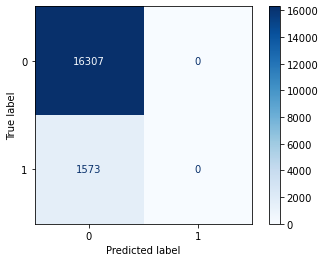

In [20]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')

In fact, we found a model which is always predicting 0!

### 3.1.4. Weighted Logistic Regression to improve ROC-AUC
[Back to top](#top)

In the following section we want to develop a class-weighted logistic regression model to handle the substantial data imbalance better. As accuracy is not a suitable metric (see initial model evaluation), we optimize it in respect to the ROC-AUC metric which describes the area under the receiver operating characteristic (ROC) curve. The ROC curve illustrates the performance of a classifier in terms of true positive rate (recall) and false positive rate as its dicrimination threshold is varied.

#### Starting point

- Calculate ROC-AUC and plot ROC curve of our basic logistic regression model

In [94]:
# calculate prediction probabilities
y_prob = clf.predict_proba(X_test)

# calculate roc-auc
roc_auc_score(y_test, y_prob[:,1])

0.6507265570411904

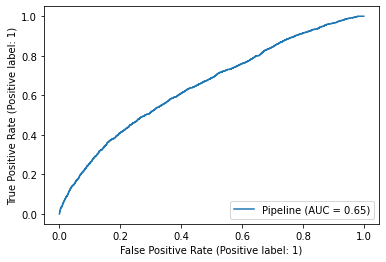

In [95]:
# plot roc curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)

We perform a Weighted Logistic Regression with 'balanced' option. It uses the following formula to calculate the class weights: ``n_samples / (n_classes * np.bincount(y))``, hence it uses the following weights in our case: 

In [55]:
print(f'Class weights in "balanced" mode: {y_train.shape[0] / (y_train.nunique() * np.bincount(y_train))}')

Class weights in "balanced" mode: [0.548244   5.68199153]


This means that the instances of the minority class are weighted around ten times more within the model than the instances of the majority class. This reflects the fact that the majority class has about 10 times more instances than the minority class in the dataset.

In [46]:
# define model
clf_balanced = make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))

In [47]:
# fit model
%time clf_balanced.fit(X_train, y_train)

Wall time: 13.6 s


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [97]:
# calculate probability estimates
y_prob = clf_balanced.predict_proba(X_test)

# calculate roc-auc
roc_auc_score(y_test, y_prob[:,1])

0.6514416973338686

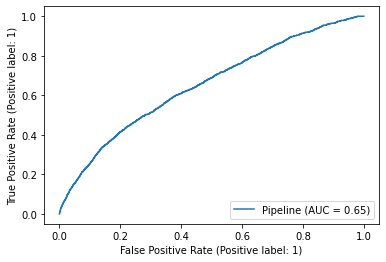

In [48]:
# plot roc curve
RocCurveDisplay.from_estimator(clf_balanced, X_test, y_test)

We see a small improvement in the ROC-AUC metric using the inverse ratio of the training data (the 'balanced' mode). However, this is a heuristic which does not necessarily yield the best results out of all class weight combinations (https://machinelearningmastery.com/cost-sensitive-logistic-regression/). We conduct a grid search which brute forces different weights in order to confirm our assumption that the 'balanced' weighting yields the best results or to further improve our ROC-AUC metric.

In [98]:
weight_grid = {'logisticregression__class_weight': [{0: 1, 1: 1}, 
                                                    {0: 1, 1: 10}, 
                                                    {0: 1, 1: 100},
                                                    {0: 1, 1: 1000},
                                                    'balanced']}

In [99]:
weight_search = GridSearchCV(clf, param_grid=weight_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)

In [86]:
%time weight_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Wall time: 2min 24s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'logisticregression__class_weight': [{0: 1, 1: 0.1},
                                                              {0: 1, 1: 1},
                                                              {0: 1, 1: 10},
                                                              {0: 1, 1: 100},
                                                              {0: 1, 1: 1000},
                                                              'balanced']},
             scoring='roc_auc', verbose=1)

In [87]:
ws_cv_results = pd.DataFrame(weight_search.cv_results_)

ws_cv_results.loc[:, ['param_logisticregression__class_weight', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)

,param_logisticregression__class_weight,mean_test_score
5,balanced,0.645640
2,"{0: 1, 1: 10}",0.645496
1,"{0: 1, 1: 1}",0.644422
3,"{0: 1, 1: 100}",0.644043
4,"{0: 1, 1: 1000}",0.643280
0,"{0: 1, 1: 0.1}",0.641992


As expected, the best cross-validated ROC-AUC are obtained by the balancing heuristic and the 1:10 weighting which is really close. It is not better to weight the minority class even more.

#### Threshold moving

The ROC-AUC metric provides a measure of performance across all possible discrimination thresholds. To have the best possible model we have to choose the threshold which suits the purpose of the model. A common way to choose the threshold is to maximize the geometric mean between the two dimensions of the ROC curve, true positive rate and false positive rate.

In [111]:
# predict probabilities
y_prob = clf_balanced.predict_proba(X_test)

# probabilities for the positive outcome only
y_prob_1 = y_prob[:, 1]

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_1)

# calculate g-mean for every threshold
gmeans = np.sqrt(tpr * (1-fpr))

In [110]:
# Save in dataframe and sort by gmean

df_thresh = pd.DataFrame({'Threshold': thresholds, 'FPR': fpr, 'TPR': tpr, 'GMean': gmeans})
df_thresh.sort_values(by='GMean', ascending=False)

,Threshold,FPR,TPR,GMean
1617,0.484779,0.374686,0.593134,0.609012
1613,0.485987,0.371374,0.589955,0.608984
1611,0.486138,0.370884,0.589320,0.608893
1635,0.482311,0.381615,0.599491,0.608865
1621,0.484019,0.376648,0.594406,0.608707
...,...,...,...,...
4,0.964480,0.000123,0.001907,0.043669
1,0.984316,0.000000,0.000636,0.025214
2,0.974490,0.000061,0.000636,0.025213
0,1.984316,0.000000,0.000000,0.000000


In [113]:
# get the best threshold
best_thresh = thresholds[np.argmax(gmeans)]
best_thresh

0.4847793094556708

- Evaluate the resulting classification

In [120]:
# calculate probability estimates for class 1
y_prob = clf_balanced.predict_proba(X_test)
y_prob_1 = y_prob[:,1]

#calculate predictions using custom discrimination threshold
y_pred = (y_prob_1 >= best_thresh).astype(int)

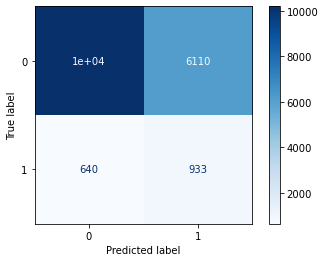

In [122]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')

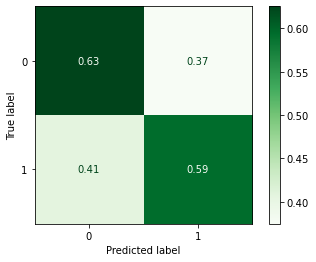

In [124]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', cmap='Greens')

In [121]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.63      0.75     16307
           1       0.13      0.59      0.22      1573

    accuracy                           0.62     17880
   macro avg       0.54      0.61      0.48     17880
weighted avg       0.87      0.62      0.70     17880



From a minority class perspective we improved our model significantly. While the basic logistic regression misclassified almost every minority class instance, the weighted model is classifying 59% correctly (=recall). This happened at the expense of overall accuracy since many majority class instances are now misclassified as well.

#### c) PR-AUC

In [23]:
In the previous section ROC-AUC metric 

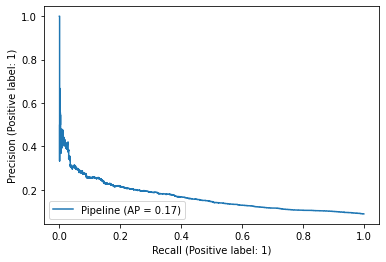

In [45]:
PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)

In [31]:
cla

NameError: name 'cla' is not defined

In [ ]:
# evaluate model
y_pred = weighted_clf.predict(X_test)
print(roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
RocCurveDisplay.from_estimator(weighted_clf, X_test, y_test)

### 3.1.5. Calibration
[Back to top](#top)

The logistic regression model returns well calibrated predictions by default as it directly optimizes the log loss which is defined on probability outputs (https://scikit-learn.org/stable/modules/model_evaluation.html#log-loss)

In [ ]:
y_prob = weighted_clf.predict_proba(X_test)

In [ ]:
# scikit-learn 1.0 needed
# show calibration curve of current model

CalibrationDisplay.from_estimator(weighted_clf, X_test, y_test)

In [ ]:
# fit and calibrate model on training data
calibrated_model = CalibratedClassifierCV(weighted_clf, n_jobs=-1)
%time calibrated_model.fit(X_train, y_train)

In [ ]:
# scikit-learn 1.0 needed
# show calibration curve of calibrated model

CalibrationDisplay.from_estimator(calibrated_model, X_test, y_test)

In [ ]:
print(classification_report(y_test, calibrated_model.predict(X_test)))

### 3.1.6. Threshold Moving
[Back to top](#top)

https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

- Optimal threshold for ROC curve

- Optimal threshold for precision-recall curve (focus on minority class): f1 optimization

In [ ]:
y_prob = weighted_clf.predict_proba(X_test)[:, 1]
PrecisionRecallDisplay.from_predictions(y_test, y_prob)

In [ ]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

# predict probabilities
yhat = clf_lr.predict_proba(X_test)

# keep probabilities for the positive outcome only
probs = yhat[:, 1]

# define thresholds
thresholds = np.arange(0, 1, 0.001)

# evaluate each threshold
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]

# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

### Conclusion LogReg

Being in a medicine context,...